## Librerías necesarias

In [1]:
import gc
from os import getcwd
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import gc
import tensorflow as tf
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

pd.set_option("display.max_columns", 80)

## Carga del conjunto de datos

In [2]:
df = pd.read_csv('../Data Preprocess/autoencoder-preprocesed.csv', sep=',', low_memory=False)

num_cols = df.columns[:-3]
df

Dst Port       xhr       yhr  Flow Duration  Tot Fwd Pkts  \
0         0.000000  0.866025  0.254333       0.999991      0.000006   
1         0.000000  0.866025  0.254333       0.999991      0.000006   
2         0.000000  0.866025  0.254333       0.999991      0.000006   
3         0.000351  0.866025  0.254333       0.999855      0.000000   
4         0.000000  0.866025  0.254333       0.999991      0.000006   
...            ...       ...       ...            ...           ...   
14597098  0.001221  0.707107  0.148985       0.999856      0.000006   
14597099  0.001221  0.707107  0.148985       0.999856      0.000003   
14597100  0.006760  0.707107  0.148985       0.999855      0.000006   
14597101  0.764782  0.707107  0.148985       0.999855      0.000006   
14597102  0.764645  0.707107  0.148985       0.999855      0.000006   

          Tot Bwd Pkts  TotLen Fwd Pkts  Fwd Pkt Len Max  Fwd Pkt Len Min  \
0             0.000000         0.000000         0.000000              0.0   
1             0.000000         0.000000         0.000000              0.0   
2             0.000000         0.000000         0.000000              0.0   
3             0.000691         0.000000         0.000000              0.0   
4             0.000000         0.000000         0.000000              0.0   
...                ...              ...              ...              ...   
14597098      0.002762         0.000016         0.079193              0.0   
14597099      0.000000         0.000000         0.000000              0.0   
14597100      0.000000         0.000008         0.022627              0.0   
14597101      0.000000         0.000003         0.015248              0.0   
14597102      0.000000         0.000003         0.015248              0.0   

          Fwd Pkt Len Mean  Bwd Pkt Len Max  Bwd Pkt Len Min  \
0                 0.000000         0.000000              0.0   
1                 0.000000         0.000000              0.0   
2                 0.000000         0.000000              0.0   
3                 0.000000         0.000000              0.0   
4                 0.000000         0.000000              0.0   
...                    ...              ...              ...   
14597098          0.037257         0.121635              0.0   
14597099          0.000000         0.000000              0.0   
14597100          0.017819         0.000000              0.0   
14597101          0.007174         0.000000              0.0   
14597102          0.007174         0.000000              0.0   

          Bwd Pkt Len Mean  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
0                 0.000000       0.999926  5.406509e-10      0.999926   
1                 0.000000       0.999926  1.028892e-09      0.999926   
2                 0.000000       0.999926  3.199770e-10      0.999926   
3                 0.000000       0.999858  0.000000e+00      0.999858   
4                 0.000000       0.999926  2.206738e-11      0.999926   
...                    ...            ...           ...           ...   
14597098          0.066158       0.999858  6.146874e-07      0.999858   
14597099          0.000000       0.999858  0.000000e+00      0.999858   
14597100          0.000000       0.999858  6.068530e-10      0.999858   
14597101          0.000000       0.999858  8.275269e-12      0.999858   
14597102          0.000000       0.999858  6.068530e-11      0.999858   

          Bwd IAT Tot  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0            0.000000      0.000000     0.000000     0.000000     0.000000   
1            0.000000      0.000000     0.000000     0.000000     0.000000   
2            0.000000      0.000000     0.000000     0.000000     0.000000   
3            0.000000      0.000000     0.000000     0.000000     0.000000   
4            0.000000      0.000000     0.000000     0.000000     0.000000   
...               ...           ...          ...          ...          ...   
14597098     0.003221      0.008549     

## Tratamiento del conjunto de datos

In [6]:
cols = ['Dst Port', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkts/s', 'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min', 'Protocol_6', 'Protocol_17', 'Label']
df = df[cols]

In [7]:
y = df.pop('Label')
X = df.values

In [3]:
# 1 -> DoS
# 2 -> DDoS
# 3 -> Botnet
# 4 -> Bruteforce
# 5 -> Infiltration
# 6 -> Web attack
df.replace(to_replace=2, value=1, inplace=True)     # DoS attack
df.replace(to_replace=3, value=1, inplace=True)     # DoS attack
df.replace(to_replace=4, value=1, inplace=True)     # DoS attack
df.replace(to_replace=5, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=6, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=7, value=2, inplace=True)     # DDoS+PortScan
df.replace(to_replace=8, value=3, inplace=True)     # Botnet attack
df.replace(to_replace=9, value=4, inplace=True)     # Bruteforce attack
df.replace(to_replace=10, value=4, inplace=True)    # Bruteforce attack
df.replace(to_replace=11, value=5, inplace=True)    # Infiltration attack
df.replace(to_replace=12, value=6, inplace=True)    # Web attack
df.replace(to_replace=13, value=6, inplace=True)    # Web attack
df.replace(to_replace=14, value=6, inplace=True)    # Web attack
df['Label'].unique()

array([0, 1, 5, 3, 6, 2, 4])

## Partición de conjuntos normales y anómalos

Se entrenará el autoencoder utilizando sólo los flujos normales, que en este conjunto de datos están etiquetados como 0. Deben separarse los flujos normales de los anómalos.

In [8]:
# Partición del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [9]:
def count_values(array):
    y = np.bincount(array)
    ii = np.nonzero(y)[0]
    return np.vstack((ii,y[ii])).T

In [10]:
count_values(y_train)

array([[      0, 8321233],
       [      1,  444327],
       [      2,  885080],
       [      3,  200526],
       [      4,  266748],
       [      5,   99400],
       [      6,     658]])

In [11]:
count_values(y_test)

array([[      0, 3567467],
       [      1,  190047],
       [      2,  378823],
       [      3,   85642],
       [      4,  114201],
       [      5,   42681],
       [      6,     270]])

In [12]:
test_data = tf.cast(X_test, tf.float32)

In [13]:
test_labels = tf.cast(y_test, tf.int16)
train_labels = tf.cast(y_train, tf.int16)

In [14]:
normal_test_data = X_test[np.where(test_labels == 0)]
normal_train_data = X_train[np.where(train_labels == 0)]
anomalous_train_data = X_train[np.where(train_labels != 0)]

## Carga del modelo

In [15]:
autoencoder = tf.keras.models.load_model('/home/jovyan/My-Notebooks/Anomaly Detection/autoencoder/ae-hyper')

In [16]:
autoencoder.summary()

Model: "anomaly_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3)                 503       
                                                                 
 sequential_1 (Sequential)   (None, 10)                80        
                                                                 
Total params: 583
Trainable params: 583
Non-trainable params: 0
_________________________________________________________________


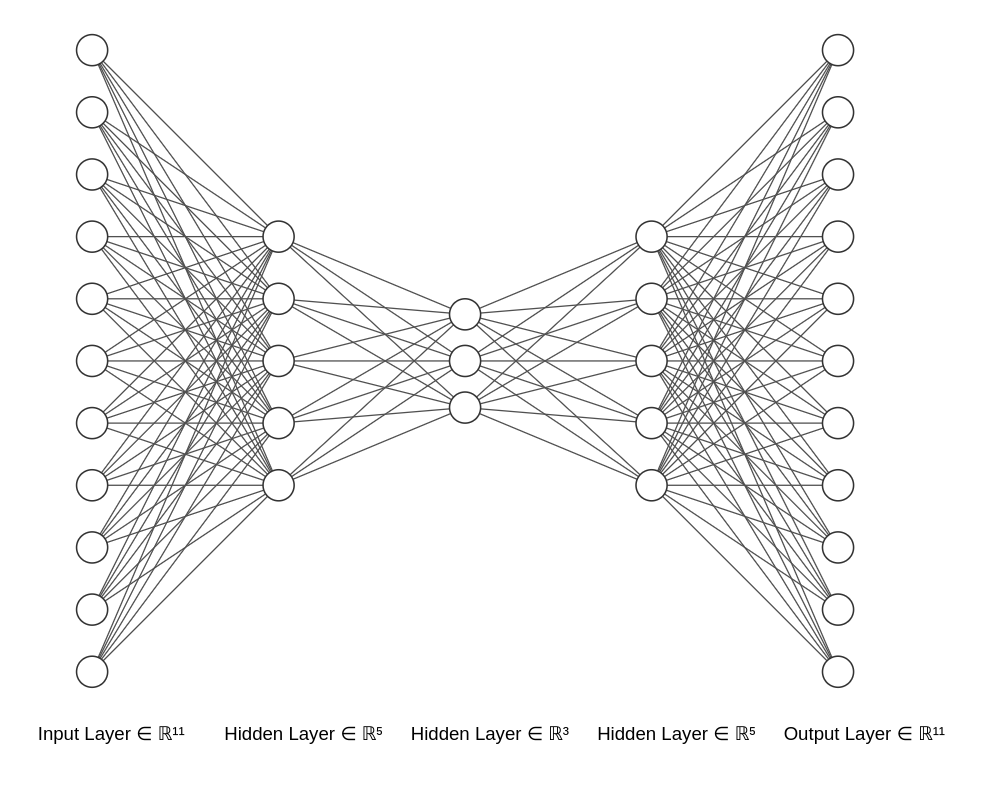

## Resultados

111484/111484 [==============================] - 128s 1ms/step


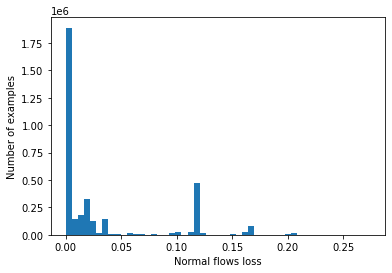

In [20]:
reconstructions = autoencoder.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Normal flows loss")
plt.ylabel("Number of examples")
plt.show()

In [21]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: " + str(threshold))
th = 0.018

Threshold: 0.08092648195718755


27771/27771 [==============================] - 31s 1ms/step


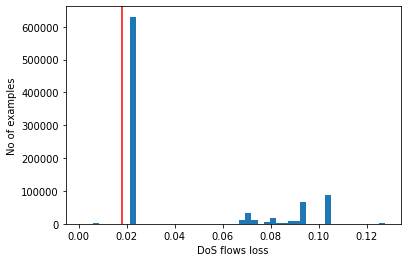

Anomalies detected: 99.7738152306747 %.


In [22]:
dos = np.concatenate((X_train[np.where(train_labels == 1)], X_train[np.where(train_labels == 1)]))
reconstructions = autoencoder.predict(dos)
test_loss = tf.keras.losses.mae(reconstructions, dos)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DoS flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

39497/39497 [==============================] - 45s 1ms/step


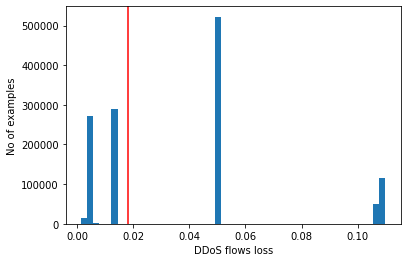

Anomalies detected: 54.27726653073851 %.


In [23]:
ddos = np.concatenate((X_test[np.where(test_labels == 2)], X_train[np.where(train_labels == 2)]))
reconstructions = autoencoder.predict(ddos)
test_loss = tf.keras.losses.mae(reconstructions, ddos)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("DDoS flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

8943/8943 [==============================] - 10s 1ms/step


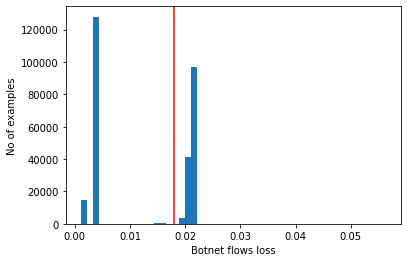

Anomalies detected: 49.643566017164744 %.


In [24]:
bot = np.concatenate((X_test[np.where(test_labels == 3)], X_train[np.where(train_labels == 3)]))
reconstructions = autoencoder.predict(bot)
test_loss = tf.keras.losses.mae(reconstructions, bot)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Botnet flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

11905/11905 [==============================] - 13s 1ms/step


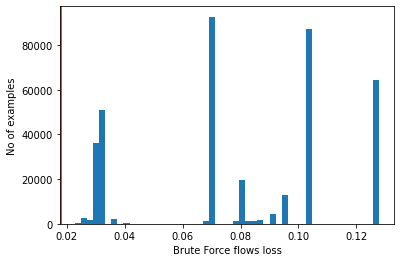

Anomalies detected: 100.0 %.


In [25]:
brute_force = np.concatenate((X_test[np.where(test_labels == 4)], X_train[np.where(train_labels == 4)]))
reconstructions = autoencoder.predict(brute_force)
test_loss = tf.keras.losses.mae(reconstructions, brute_force)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Brute Force flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

4441/4441 [==============================] - 5s 1ms/step


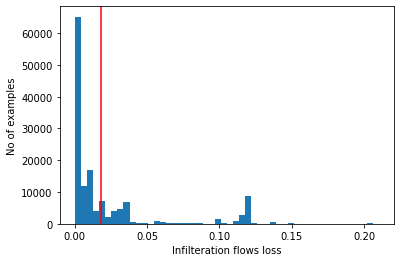

Anomalies detected: 27.683504479838966 %.


In [26]:
inf = np.concatenate((X_test[np.where(test_labels == 5)], X_train[np.where(train_labels == 5)]))
reconstructions = autoencoder.predict(inf)
test_loss = tf.keras.losses.mae(reconstructions, inf)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Infilteration flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

29/29 [==============================] - 0s 2ms/step


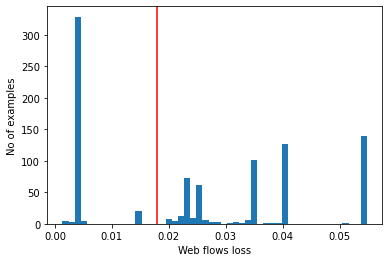

Anomalies detected: 60.991379310344826 %.


In [27]:
web = np.concatenate((X_test[np.where(test_labels == 6)], X_train[np.where(train_labels == 6)]))
reconstructions = autoencoder.predict(web)
test_loss = tf.keras.losses.mae(reconstructions, web)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Web flows loss")
plt.ylabel("No of examples")
plt.axvline(x = th, color = 'r', label = 'axvline - full height')
plt.show()

print("Anomalies detected: " + str((len(np.where(test_loss.numpy() > th)[0]) / len(test_loss.numpy())) * 100), "%.")

In [28]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

Deberemos elegir el valor de *threshold* que mejor creemos que separa las anomalías.

In [29]:
def pred(data, threshold):
        reconstructions = autoencoder.predict(data)
        loss = tf.keras.losses.mae(reconstructions, data)
        return tf.math.less(threshold, loss)

In [32]:
%%time
preds = pred(test_data, th)

136848/136848 [==============================] - 152s 1ms/step
CPU times: user 3min 26s, sys: 28.1 s, total: 3min 54s
Wall time: 2min 52s


In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

              precision    recall  f1-score   support

           0    0.90793   0.68565   0.78129   3567467
           1    0.33448   0.69441   0.45149    811664

    accuracy                        0.68727   4379131
   macro avg    0.62121   0.69003   0.61639   4379131
weighted avg    0.80164   0.68727   0.72016   4379131

AUC: 69.0%


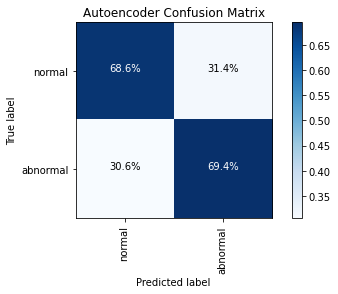

In [34]:
labels = np.where(y_test > 0, 1, y_test)
print(classification_report(labels, preds, digits=5))
print('AUC:','{:.1%}'.format(roc_auc_score(labels, preds)))
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, title='Autoencoder Confusion Matrix')

In [35]:
df = pd.read_csv('../Data Preprocess/test-SD.csv', sep=',', low_memory=False)
df = df[cols]
_ = df.pop('Label')
X_test = df.values

In [36]:
%%time
preds = pred(X_test, th)

136848/136848 [==============================] - 152s 1ms/step
CPU times: user 3min 28s, sys: 28.7 s, total: 3min 56s
Wall time: 2min 53s
